In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
from sklearn.decomposition import PCA

from pathlib import Path
import dotenv
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import get_T_inds, gen_trials_from_model_dir, gen_X_from_model_dir, make_lil_axes
from tools_lnd import find_closest_fp_loc, get_model_params


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #fig save path
# ##################################################################
fig = 'fig5'
figpath = os.path.join(p_code,'figs',fig,fig+'_BCEFHIKLNOQR')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [5]:
# ##################################################################
# #Find right model dir
# ##################################################################
data_fldr = 'fig3_5'
file = 'LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1'
m = os.path.join(p_data,data_fldr,file)

In [6]:
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)

cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))
perfs_changes = lesion_var['perfs_changes']

cluster_number = {}
cluster_number['Anti Stimulus'] = 5
cluster_number['Delayed Response'] = 2
cluster_number['Modality2'] = 10
cluster_number['Modality1'] = 6
cluster_names = ['Anti Stimulus','Delayed Response','Modality2','Modality1']

In [7]:
from tools_lnd import find_closest_fp_loc

def append_fps(f, h_end, fps_all = [], q_thresh = 1e-2, t_set = []):
    
    if len(t_set)==0:
        t_set = range(0,80,2)
    
    fp_struct = np.load(f)
    fp_use = np.where(fp_struct['qstar']<q_thresh)[0]
    x_star = fp_struct['xstar'][fp_use,:]
    closest_fp, _ = find_closest_fp_loc(h_end,x_star)
    
    if trial_num==t_set[0]:
        fps_all = x_star[[closest_fp,],:]
    else:
        fps_all = np.append(fps_all,x_star[[closest_fp,],:],axis = 0) 

    return fps_all


def get_filename_fp(trial, epoch,t):
    ind_stim_loc  = 180*trial.y_loc[-1,t]/np.pi
    filename = epoch+'_'+str(round(ind_stim_loc,2))+'.npz'

    return filename, ind_stim_loc

w_in, b_in, w_out, b_out = get_model_params(m)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instea

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Use `tf.global_variables_initializer` instead.


2024-04-16 09:31:03.443672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(1

/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_4912/1332721507.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_4912/1332721507.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(1

/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_4912/1332721507.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_4912/1332721507.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(1

/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_4912/1332721507.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_4912/1332721507.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(1

/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_4912/1332721507.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_4912/1332721507.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


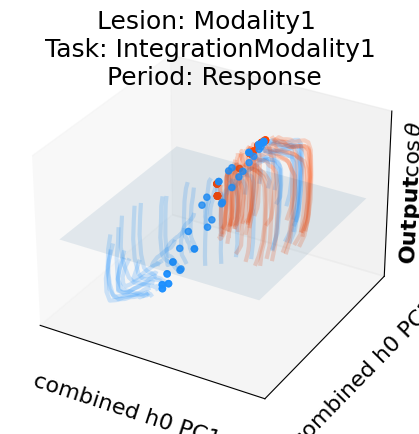

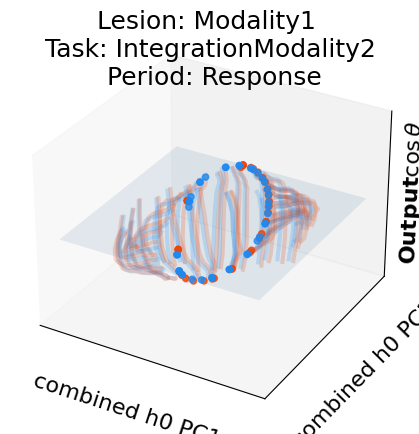

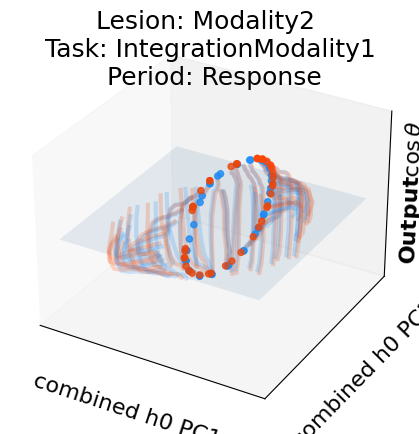

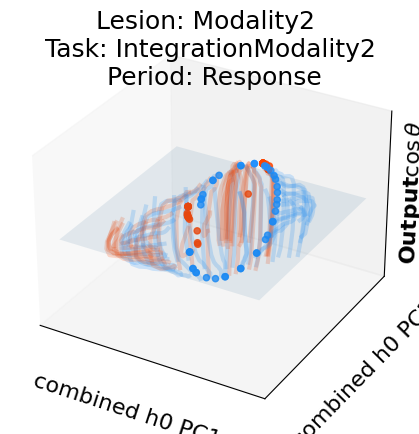

In [8]:
from tools_lnd import take_names
q_thresh = 1e-2
plot_h = 'h'
lf = 'lesion_fps_review'

plot3 = False
plot_zero_plane = False

########################
########################
########################
cluster_name_set = ['Continuous Memory','Category Memory']
rule_set = ['delaydm1','dmcgo']
use_pcs = 'prev_pc'
epoch_set =  ['delay1',]
# ########################
cluster_name_set = ['Anti Stimulus','Delayed Response']
rule_set = ['delaygo','delayanti']
use_pcs = 'pc'
epoch_set = ['stim1',]
# ########################
cluster_name_set = ['Modality1','Modality2']
rule_set = ['delaydm1','delaydm2']
use_pcs = 'prev_pc'
epoch_set = ['delay1',]
########################
########################
########################
epoch_set = ['go1',]
use_pcs = 'prev_pc'
plot3 = True
plot_zero_plane = True

for cluster_name in cluster_name_set:
    
    if cluster_name == 'Category Memory':
        lesion_cluster = 20
        lesion_units_list = []
        [lesion_units_list.append(x) for x in cluster_var['lesion_units_list'][20]] # 
        [lesion_units_list.append(x) for x in cluster_var['lesion_units_list'][21]] # 
    elif cluster_name == 'Continuous Memory':
        lesion_cluster = 1
        lesion_units_list = []
        [lesion_units_list.append(x) for x in cluster_var['lesion_units_list'][1]] # 
        [lesion_units_list.append(x) for x in cluster_var['lesion_units_list'][2]] # 
        
    else:
        lesion_cluster = cluster_number[cluster_name]+1
        lesion_units_list = cluster_var['lesion_units_list'][lesion_cluster]

    for rule in rule_set:
        
        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
        _,h_l = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units_list)
        _,h_full = gen_X_from_model_dir(m,trial)

        B = np.shape(trial.y_loc)[1]
        t_set = range(3,int(B),int(B/40))
#         t_set = range(int(B))

        for epoch in epoch_set: 

            T_inds = get_T_inds(trial,epoch) #get indices of epoch

            #if trials have diff inputs, concat fps from diff trials
            if np.any(np.diff(trial.x[T_inds[0],:,:],axis = 0)):
                skip_trials = 2
            else:
                skip_trials = int(B)

            #Make fp_set
            fps_l = []
            fps_all = []

            for trial_num in t_set:

#                 out_theta = int(180*trial.y_loc[-1,trial_num]/np.pi)
                
                if np.any(np.diff(trial.x[T_inds[0],:,:],axis = 0)):
                    filename,_ = get_filename_fp(trial,epoch,trial_num)
                else:
                    filename,_ = get_filename_fp(trial,epoch,0)

                f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(lesion_cluster),rule,filename)
                fps_l = append_fps(f, h_l[:,trial_num,[T_inds[-1],]].T, fps_all = fps_l, 
                                   q_thresh = q_thresh, t_set = t_set)

                f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(0),rule,filename)
                fps_all = append_fps(f, h_full[:,trial_num,[T_inds[-1],]].T, fps_all = fps_all, 
                                     q_thresh = q_thresh, t_set = t_set)

            #####do PCA on combined fps for viz axes
            if use_pcs=='fp':
                pca = PCA(n_components = 10)
                fps_pc = pca.fit_transform(np.append(fps_all,fps_l,axis = 0) )

                D_all = pca.components_
                x_label = 'combined FP PC1'
                y_label = 'combined FP PC2'
                axes_labels = [x_label,y_label]
            elif use_pcs=='out':
                D_all = w_out[:,1:].T

                x_label = 'output 1'
                y_label = 'output 2'
                axes_labels = [x_label,y_label]
            elif use_pcs=='prev_pc':
                pca = PCA(n_components = 10)
                h_cat = np.append(h_full[:,:,T_inds[0]-1],h_l[:,:,T_inds[0]-1],axis = 1).T
                fps_pc = pca.fit_transform(h_cat)

                D_all = pca.components_
                D_all[0,:] = -D_all[0,:]
                x_label = 'combined h0 PC1'
                y_label = 'combined h0 PC2'
                axes_labels = [x_label,y_label]
            else:
                pca = PCA(n_components = 10)
                h_cat = np.append(h_full[:,:,T_inds[-1]],h_l[:,:,T_inds[-1]],axis = 1).T
                fps_pc = pca.fit_transform(h_cat)

                D_all = pca.components_
                x_label = 'combined h_end PC1'
                y_label = 'combined h_end PC2'
                axes_labels = [x_label,y_label]
                
            
            #PLOT FPS
            if plot3:
                fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
                ax = fig.add_axes([0,0,1,1], projection='3d');
            else:
                fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
                ax = plt.subplot(1,1,1)
                
            al = .2

            if plot_h:
                for t in t_set:
                    
                    if plot3:

                        if plot_zero_plane:
                            D3 = np.concatenate((D_all[:2,:],w_out[:,1:2].T))
                        else:
                            D3 = np.concatenate((D_all[:3,:],w_out[:,1:2].T))
                            axes_labels.append(axes_labels[1][:-1]+'3')
                        
                        h = h_full[:,t,T_inds]
                        h_in_D = np.dot(D3,h)
                        ax.plot3D(h_in_D[0,:],h_in_D[1,:],h_in_D[2,:],'-', c = 'dodgerblue',linewidth = 3, alpha = al)

                        h = h_l[:,t,T_inds]
                        h_in_D = np.dot(D3,h)
                        ax.plot3D(h_in_D[0,:],h_in_D[1,:],h_in_D[2,:],'-', c = 'orangered',linewidth = 3, alpha = al)
                        
                    else:
                        h = h_full[:,t,T_inds]
                        h_in_D = np.dot(D_all,h)
                        plt.plot(h_in_D[0,:],h_in_D[1,:],'-', c = 'dodgerblue',linewidth = 3, alpha = al)
                        plt.plot(h_in_D[0,0],h_in_D[1,0],'x', c = 'dodgerblue',linewidth = 3, alpha = al, markersize = 10)
                        plt.plot(h_in_D[0,-1],h_in_D[1,-1],'^', c = 'dodgerblue',linewidth = 3, alpha = al, markersize = 10)

                        h = h_l[:,t,T_inds]
                        h_in_D = np.dot(D_all,h)
                        plt.plot(h_in_D[0,:],h_in_D[1,:],'-', c = 'orangered',linewidth = 3, alpha = al)
                        plt.plot(h_in_D[0,0],h_in_D[1,0],'x', c = 'orangered',linewidth = 3, alpha = al, markersize = 10)
                        plt.plot(h_in_D[0,-1],h_in_D[1,-1],'^', c = 'orangered',linewidth = 3, alpha = al, markersize = 10)

            
            
            if plot3:
                fp_in_D_all = np.dot(D3,fps_all.T)
                fp_in_D_l = np.dot(D3,fps_l.T)
                ax.scatter(fp_in_D_all[0,:],fp_in_D_all[1,:],fp_in_D_all[2,:],'o', c = 'dodgerblue',alpha = .8, s = 20)
                ax.scatter(fp_in_D_l[0,:],fp_in_D_l[1,:],fp_in_D_l[2,:],'o', c = 'orangered',alpha = .8, s = 20)
            else:
                fp_in_D_all = np.dot(D_all,fps_all.T)
                fp_in_D_l = np.dot(D_all,fps_l.T)
                plt.plot(fp_in_D_all[0,:],fp_in_D_all[1,:],'o', c = 'dodgerblue',alpha = .8)#, markersize = 10)
                plt.plot(fp_in_D_l[0,:],fp_in_D_l[1,:],'o', c = 'orangered',alpha = .8)#, markersize = 10)


            if plot3:
                if plot_zero_plane:

                    [x1,x2] = ax.get_xlim()
                    [y1,y2] = ax.get_ylim()

                    zlabel = 'out_null'
                    save_axes = zlabel
                    xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
                    z = xx*0
                    ax.plot_surface(xx, yy, z, alpha=0.1)
                    ax.set_zlabel(r"$\bf{Output}$"+r'$\cos{\theta}$',labelpad=-10, fontsize = 16)
#                 ax.text(x1, y1, 0, 'Output Null', (1,0,0))
                    ax.set_zlim([-.9,.9])
                
                else:
                    ax.set_zlabel(axes_labels[2],fontsize = 16)
                
                ax.set_xlabel(axes_labels[0],fontsize = 16)
                ax.set_ylabel(axes_labels[1],fontsize = 16)
                ax.set_zticks([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.dist = 12
                
                
            else:
                make_lil_axes(ax,axes_labels,fontsize = 16,fac_len = 1)
                
            epoch_name, rule_name, _, _ = take_names(epoch,rule,epoch_axes = epoch, h_epoch = epoch)
            tit = 'Lesion: '+ cluster_name + ' \n Task: ' + rule_name + ' \n Period: ' +epoch_name
            plt.title(tit,fontsize = 18,y = .9)

            #save figs
            if plot3:
                figname = '_'.join(('plot3',cluster_name,rule_name,epoch_name,x_label))
            else:
                figname = '_'.join((cluster_name,rule_name,epoch_name,x_label))
                  
            plt.savefig(os.path.join(figpath,figname+'.pdf'), bbox_inches='tight')

In [9]:
os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(0),rule,filename)

'/Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/lesion_fps_hierarchical_ward_distance_opt_clust/lesion_fps_review/tf_fixed_pts_lesion0/delaydm2/go1_180.0.npz'